In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import warnings

# Handle class imbalance with SMOTE
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

# Suppress warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [2]:
# Define data paths
processed_dir = '../Data/processed/'
data_path = os.path.join(processed_dir, 'processed_data.csv')

# Check if processed data exists, if not load raw data and preprocess
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    print(f"Loaded processed data with shape: {df.shape}")
else:
    print("Processed data not found. Please run the Data Wrangling notebook first.")
    
# Preview the data
df.head()

Loaded processed data with shape: (36457, 24)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE_YEARS,EMPLOYMENT_YEARS,IS_UNEMPLOYED,TARGET,WORST_STATUS,MONTHS_HISTORY
0,5008804,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,1,0,0,12,2.0,32.9,12.4,True,1,1,16
1,5008805,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,1,0,0,12,2.0,32.9,12.4,True,1,1,15
2,5008806,1,1,1,0,112500.0,4,4,1,1,-21474,-1134,1,0,0,0,17,2.0,58.8,3.1,True,1,0,30
3,5008808,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,15,1.0,52.3,8.4,True,1,0,5
4,5008809,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,15,1.0,52.3,8.4,True,1,-1,5


In [3]:
# Get basic information about the dataset
print(f"Dataset dimensions: {df.shape}")
print(f"Number of features: {df.shape[1] - 1}")
print(f"Number of samples: {df.shape[0]}")
print(f"\nTarget distribution:\n{df['TARGET'].value_counts(normalize=True) * 100}")

Dataset dimensions: (36457, 24)
Number of features: 23
Number of samples: 36457

Target distribution:
TARGET
1    98.310338
0     1.689662
Name: proportion, dtype: float64


In [4]:
# Create a copy of the dataframe to avoid modifying the original one
df_fe = df.copy()

# Create a list of problematic features to exclude
problematic_features = [
    'AGE_YEARS', 'CODE_GENDER', 'NAME_FAMILY_STATUS', 
    'CNT_FAM_MEMBERS', 'CNT_CHILDREN', 'DAYS_BIRTH' 
]

# Also check for any one-hot encoded versions
encoded_problematic = []
for col in df_fe.columns:
    for feat in problematic_features:
        if feat in col:
            encoded_problematic.append(col)

# Create fair feature set
fair_features = [f for f in df_fe.columns if f not in encoded_problematic]
print(f"Removed {len(encoded_problematic)} potentially biased features")
print(f"{len(fair_features)} fair features")
df_fe = df_fe[fair_features]

Removed 6 potentially biased features
18 fair features


In [5]:

# 1. Income groups (using quantiles)
income_quantiles = [0, 0.25, 0.5, 0.75, 1.0]
income_labels = ['Low', 'Medium-Low', 'Medium-High', 'High']
income_bins = df_fe['AMT_INCOME_TOTAL'].quantile(income_quantiles).values
df_fe['INCOME_GROUP'] = pd.cut(df_fe['AMT_INCOME_TOTAL'], bins=income_bins, labels=income_labels, include_lowest=True)

# 2. Create communication channel count
communication_cols = ['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']
df_fe['COMMUNICATION_COUNT'] = df_fe[communication_cols].sum(axis=1)

# 3. Create asset ownership count
asset_cols = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
df_fe['ASSET_COUNT'] = df_fe[asset_cols].sum(axis=1)

# Display new features
new_features = ['INCOME_GROUP', 'COMMUNICATION_COUNT',
                'ASSET_COUNT']

    
df_fe[new_features].head()

,INCOME_GROUP,COMMUNICATION_COUNT,ASSET_COUNT
0,High,2,2
1,High,2,2
2,Low,1,2
3,High,3,1
4,High,3,1


In [6]:
# Convert categorical features to one-hot encoding if not already done
# Get dummies and add prefix
dummies = pd.get_dummies(df_fe['INCOME_GROUP'], prefix=col, drop_first=False)
df_fe = pd.concat([df_fe, dummies], axis=1)

In [7]:
# Identify numerical features to transform
numerical_features = ['EMPLOYMENT_YEARS', 'AMT_INCOME_TOTAL', 'MONTHS_HISTORY', 'DAYS_EMPLOYED']

# Check for skewness in numerical features
skewness = df_fe[numerical_features].skew().sort_values(ascending=False)
print("Skewness in numerical features:")
print(skewness)

Skewness in numerical features:
AMT_INCOME_TOTAL    2.739010
DAYS_EMPLOYED       1.772443
EMPLOYMENT_YEARS    1.758831
MONTHS_HISTORY      0.730050
dtype: float64


In [8]:
# Apply log transformation to highly skewed features
log_transform_features = []
for feature in numerical_features:
    if abs(skewness[feature]) > 1.0:  # Threshold for high skewness
        # Check if feature has values <= 0
        min_value = df_fe[feature].min()
        if min_value <= 0:
            # Shift values to make them positive
            shift_value = abs(min_value) + 1
            log_feature_name = f'LOG_{feature}'
            df_fe[log_feature_name] = np.log1p(df_fe[feature] + shift_value)
        else:
            log_feature_name = f'LOG_{feature}'
            df_fe[log_feature_name] = np.log1p(df_fe[feature])
        log_transform_features.append(log_feature_name)
        
print(f"Applied log transformation to {len(log_transform_features)} features: {log_transform_features}")

Applied log transformation to 3 features: ['LOG_EMPLOYMENT_YEARS', 'LOG_AMT_INCOME_TOTAL', 'LOG_DAYS_EMPLOYED']


In [9]:
# Handle outliers by capping (winsorization)
for feature in numerical_features:
    # Calculate upper and lower bounds (1st and 99th percentiles)
    lower_bound = df_fe[feature].quantile(0.01)
    upper_bound = df_fe[feature].quantile(0.99)
    
    # Cap the values
    capped_feature_name = f'CAPPED_{feature}'
    df_fe[capped_feature_name] = df_fe[feature].clip(lower=lower_bound, upper=upper_bound)
    
print(f"Applied capping to {len(numerical_features)} features")

Applied capping to 4 features


In [10]:
# Scale numerical features using RobustScaler (less sensitive to outliers)
scaler = RobustScaler()

# Apply scaling to both original and transformed numerical features
features_to_scale = df_fe.columns.tolist()

features_to_scale = [x for x in features_to_scale if x not in ['ID', 'TARGET', 'WORST_STATUS', 'INCOME_GROUP']]
# Create a DataFrame for scaled features
scaled_features = pd.DataFrame(scaler.fit_transform(df_fe[features_to_scale]), 
                              columns=[f'SCALED_{f}' for f in features_to_scale],
                              index=df_fe.index)

# Concatenate scaled features with original dataframe
df_fe = pd.concat([df_fe, scaled_features], axis=1)

print(f"Applied scaling to {len(features_to_scale)} features")

Applied scaling to 28 features


In [11]:
# Separate data into features and target
# First, drop ID and other non-feature columns
drop_cols = ['ID', 'TARGET', 'WORST_STATUS', 'INCOME_GROUP']
X = df_fe.drop(columns=drop_cols, errors='ignore')
y = df_fe['TARGET']

# Get a list of all features
feature_names = X.columns.tolist()
print(f"Total number of features: {len(feature_names)}")

Total number of features: 56


In [12]:
# SMOTE for synthetic samples of minority class
X_balanced, y_balanced = SMOTE(random_state=42).fit_resample(X, y)

In [13]:
# Feature selection using ANOVA F-value (for classification)

k = min(50, len(feature_names))  # Select top k features, but not more than we have

# Apply SelectKBest with f_classif score function
selector = SelectKBest(f_classif, k=k)
X_selected = selector.fit_transform(X_balanced, y_balanced)

# Get selected feature indices and names
selected_indices = selector.get_support(indices=True)
selected_features_f = [feature_names[i] for i in selected_indices]
selected_scores_f = selector.scores_[selected_indices]

# Create a DataFrame of features and their scores
f_feature_scores = pd.DataFrame({
    'Feature': selected_features_f,
    'F_Score': selected_scores_f
}).sort_values('F_Score', ascending=False)

print("Top 10 features by F-score:")
print(f_feature_scores.head(10))

Top 10 features by F-score:
                         Feature       F_Score
48  SCALED_CAPPED_MONTHS_HISTORY  13153.509094
36         SCALED_MONTHS_HISTORY  13144.828714
24         CAPPED_MONTHS_HISTORY  12169.054820
12                MONTHS_HISTORY  12163.860841
1                FLAG_OWN_REALTY   5062.553423
14                   ASSET_COUNT   4337.377282
0                   FLAG_OWN_CAR   2532.619604
7                     FLAG_PHONE   2381.390974
13           COMMUNICATION_COUNT   1570.909382
6                FLAG_WORK_PHONE   1544.563068


In [14]:
# Feature selection using mutual information
selector_mi = SelectKBest(mutual_info_classif, k=k)
X_selected_mi = selector_mi.fit_transform(X_balanced, y_balanced)

# Get selected feature indices and names
selected_indices_mi = selector_mi.get_support(indices=True)
selected_features_mi = [feature_names[i] for i in selected_indices_mi]
selected_scores_mi = selector_mi.scores_[selected_indices_mi]

# Create a DataFrame of features and their scores
mi_feature_scores = pd.DataFrame({
    'Feature': selected_features_mi,
    'MI_Score': selected_scores_mi
}).sort_values('MI_Score', ascending=False)

print("Top 10 features by Mutual Information:")
print(mi_feature_scores.head(10))

Top 10 features by Mutual Information:
                           Feature  MI_Score
38           SCALED_MONTHS_HISTORY  0.574782
48    SCALED_CAPPED_MONTHS_HISTORY  0.572944
22         CAPPED_EMPLOYMENT_YEARS  0.358000
46  SCALED_CAPPED_EMPLOYMENT_YEARS  0.357221
12                EMPLOYMENT_YEARS  0.356938
37         SCALED_EMPLOYMENT_YEARS  0.356270
43     SCALED_LOG_EMPLOYMENT_YEARS  0.354898
19            LOG_EMPLOYMENT_YEARS  0.352606
25            CAPPED_DAYS_EMPLOYED  0.328678
49     SCALED_CAPPED_DAYS_EMPLOYED  0.327824


In [15]:
# Feature selection using Random Forest importance
# Split data to avoid overfitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# SMOTE for synthetic samples of minority class
X_train_balanced, y_train_balanced = SMOTE(random_state=42).fit_resample(X_train, y_train)

# Train a Random Forest model
rf = RandomForestClassifier(class_weight={0: 4, 1: 1}, n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_balanced, y_train_balanced)

# Get feature importances
rf_importances = rf.feature_importances_
rf_feature_scores = pd.DataFrame({
    'Feature': feature_names,
    'RF_Importance': rf_importances
}).sort_values('RF_Importance', ascending=False)

print("Top 10 features by Random Forest importance:")
print(rf_feature_scores.head(10))

Top 10 features by Random Forest importance:
                         Feature  RF_Importance
42         SCALED_MONTHS_HISTORY       0.081352
54  SCALED_CAPPED_MONTHS_HISTORY       0.078691
26         CAPPED_MONTHS_HISTORY       0.049376
14                MONTHS_HISTORY       0.044669
44            SCALED_ASSET_COUNT       0.037681
32    SCALED_NAME_EDUCATION_TYPE       0.031655
39        SCALED_OCCUPATION_TYPE       0.031000
43    SCALED_COMMUNICATION_COUNT       0.028983
29        SCALED_FLAG_OWN_REALTY       0.027269
37             SCALED_FLAG_PHONE       0.026706


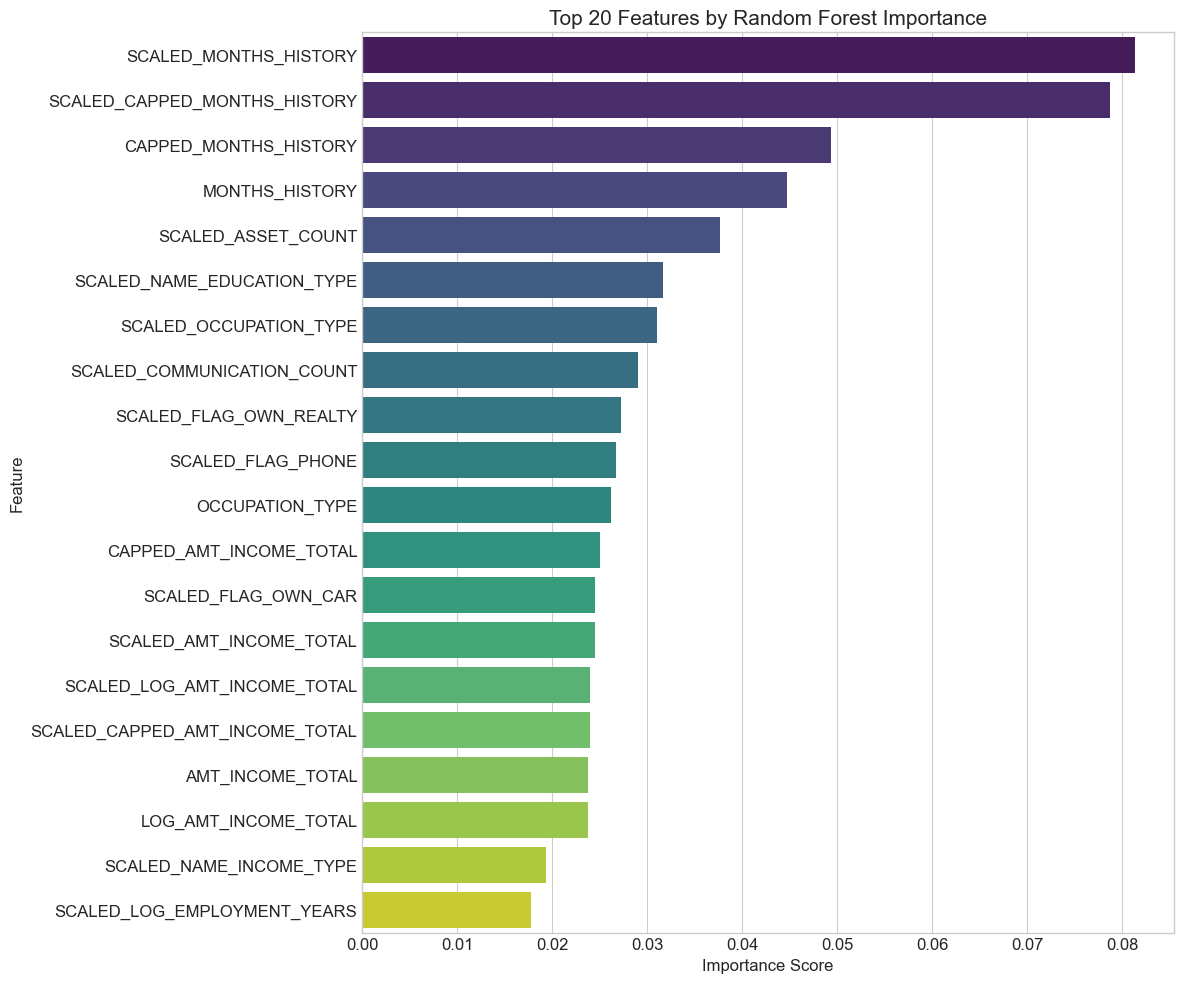

In [16]:
# Visualize the top 20 features by Random Forest importance
plt.figure(figsize=(12, 10))
top_n = 20
top_rf_features = rf_feature_scores.head(top_n)

sns.barplot(x='RF_Importance', y='Feature', data=top_rf_features, palette='viridis')
plt.title(f'Top {top_n} Features by Random Forest Importance', fontsize=15)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

In [17]:
# Combine the feature selection methods
# Create a unified score by ranking features across all methods
f_rank = f_feature_scores.copy()
f_rank['F_Rank'] = f_rank['F_Score'].rank(ascending=False)

mi_rank = mi_feature_scores.copy()
mi_rank['MI_Rank'] = mi_rank['MI_Score'].rank(ascending=False)

rf_rank = rf_feature_scores.copy()
rf_rank['RF_Rank'] = rf_rank['RF_Importance'].rank(ascending=False)

# Combine the rankings
combined_rank = pd.merge(f_rank[['Feature', 'F_Rank']], mi_rank[['Feature', 'MI_Rank']], on='Feature', how='outer')
combined_rank = pd.merge(combined_rank, rf_rank[['Feature', 'RF_Rank']], on='Feature', how='outer')

# Fill NaN values with max rank + 1
max_f_rank = combined_rank['F_Rank'].max() + 1
max_mi_rank = combined_rank['MI_Rank'].max() + 1
max_rf_rank = combined_rank['RF_Rank'].max() + 1

combined_rank['F_Rank'] = combined_rank['F_Rank'].fillna(max_f_rank)
combined_rank['MI_Rank'] = combined_rank['MI_Rank'].fillna(max_mi_rank)
combined_rank['RF_Rank'] = combined_rank['RF_Rank'].fillna(max_rf_rank)

# Calculate average rank
combined_rank['Avg_Rank'] = (combined_rank['F_Rank'] + combined_rank['MI_Rank'] + combined_rank['RF_Rank']) / 3

# Sort by average rank
combined_rank = combined_rank.sort_values('Avg_Rank')

print("Top 20 features by combined ranking:")
print(combined_rank.head(20))

Top 20 features by combined ranking:
                           Feature  F_Rank  MI_Rank  RF_Rank   Avg_Rank
1            SCALED_MONTHS_HISTORY     2.0      1.0      1.0   1.333333
0     SCALED_CAPPED_MONTHS_HISTORY     1.0      2.0      2.0   1.666667
2            CAPPED_MONTHS_HISTORY     3.0     23.0      3.0   9.666667
3                   MONTHS_HISTORY     4.0     24.0      4.0  10.666667
15     SCALED_LOG_EMPLOYMENT_YEARS    16.0      7.0     20.0  14.333333
21              SCALED_ASSET_COUNT    22.0     17.0      5.0  14.666667
22          SCALED_OCCUPATION_TYPE    23.0     14.0      7.0  14.666667
16            LOG_EMPLOYMENT_YEARS    17.0      8.0     21.0  15.333333
14         CAPPED_EMPLOYMENT_YEARS    15.0      3.0     29.0  15.666667
18          SCALED_FLAG_OWN_REALTY    19.0     20.0      9.0  16.000000
13  SCALED_CAPPED_EMPLOYMENT_YEARS    14.0      4.0     31.0  16.333333
11         SCALED_EMPLOYMENT_YEARS    12.0      6.0     32.0  16.666667
12                EMPLOYMEN

In [18]:
# Select top features from combined ranking
def select_best_features_by_group(combined_rank, max_features=30):
    """
    Select the best transformation for each base feature using their average rank.
    """
    # Define transformation prefixes
    transformation_prefixes = ['LOG_', 'SCALED_', 'CAPPED_', 'SCALED_LOG_', 'SCALED_CAPPED_']
    
    # Group features by their base name
    feature_groups = {}
    
    for feature in combined_rank['Feature']:
        # Extract base feature by removing all transformation prefixes
        base_feature = feature
        transformed = False
        
        for prefix in transformation_prefixes:
            if feature.startswith(prefix):
                # Remove the prefix to get the base feature
                transformed = True
                base_feature = feature[len(prefix):]
                # Continue checking for nested transformations (e.g., SCALED_LOG_)
                for inner_prefix in transformation_prefixes:
                    if base_feature.startswith(inner_prefix):
                        base_feature = base_feature[len(inner_prefix):]
        
        # Special case handling for dual transformations that might not be caught
        for prefix1 in transformation_prefixes:
            for prefix2 in transformation_prefixes:
                if prefix1 != prefix2 and feature.startswith(prefix1) and feature[len(prefix1):].startswith(prefix2):
                    base_feature = feature[len(prefix1) + len(prefix2):]
        
        # Add to appropriate group
        if base_feature not in feature_groups:
            feature_groups[base_feature] = []
        feature_groups[base_feature].append(feature)
    
    # Print the groups to verify correct grouping
    print(f"Found {len(feature_groups)} unique base features")
    for base, variants in list(feature_groups.items())[:5]:  # Print first 5 for verification
        print(f"Base: {base}, Variants: {variants}")
    
    # Select the best transformation for each base feature
    selected_features = []
    for base, transformations in feature_groups.items():
        if transformations:
            # Get the best (lowest) average rank for this base feature
            best_rank = float('inf')
            best_feature = None
            
            for feature in transformations:
                rank = combined_rank[combined_rank['Feature'] == feature]['Avg_Rank'].values[0]
                if rank < best_rank:
                    best_rank = rank
                    best_feature = feature
            
            if best_feature:
                selected_features.append((best_feature, best_rank))
    
    # Sort by rank and take top max_features
    selected_features.sort(key=lambda x: x[1])
    top_features = [feature for feature, rank in selected_features[:max_features]]
    
    print(f"\nSelected {len(top_features)} unique base features (best transformation of each)")
    for i, feature in enumerate(top_features[:10]):
        print(f"{i+1}. {feature}")
    
    return top_features

# Use the new function to select features
final_features = select_best_features_by_group(combined_rank, max_features=30)

# Create the final feature-engineered dataset with the selected features
final_columns = final_features + ['ID', 'TARGET']
final_df = df_fe[final_columns].copy()

print(f"Final dataset shape: {final_df.shape}")
print(f"Selected {len(final_features)} features for modeling")

Found 21 unique base features
Base: MONTHS_HISTORY, Variants: ['SCALED_MONTHS_HISTORY', 'SCALED_CAPPED_MONTHS_HISTORY', 'CAPPED_MONTHS_HISTORY', 'MONTHS_HISTORY']
Base: EMPLOYMENT_YEARS, Variants: ['SCALED_LOG_EMPLOYMENT_YEARS', 'LOG_EMPLOYMENT_YEARS', 'CAPPED_EMPLOYMENT_YEARS', 'SCALED_CAPPED_EMPLOYMENT_YEARS', 'SCALED_EMPLOYMENT_YEARS', 'EMPLOYMENT_YEARS']
Base: ASSET_COUNT, Variants: ['SCALED_ASSET_COUNT', 'ASSET_COUNT']
Base: OCCUPATION_TYPE, Variants: ['SCALED_OCCUPATION_TYPE', 'OCCUPATION_TYPE']
Base: FLAG_OWN_REALTY, Variants: ['SCALED_FLAG_OWN_REALTY', 'FLAG_OWN_REALTY']

Selected 21 unique base features (best transformation of each)
1. SCALED_MONTHS_HISTORY
2. SCALED_LOG_EMPLOYMENT_YEARS
3. SCALED_ASSET_COUNT
4. SCALED_OCCUPATION_TYPE
5. SCALED_FLAG_OWN_REALTY
6. SCALED_NAME_EDUCATION_TYPE
7. SCALED_COMMUNICATION_COUNT
8. SCALED_NAME_INCOME_TYPE
9. SCALED_LOG_DAYS_EMPLOYED
10. SCALED_FLAG_PHONE
Final dataset shape: (36457, 23)
Selected 21 features for modeling


In [19]:
# Create engineered data directory if it doesn't exist
engineered_dir = '../Data/engineered/'
os.makedirs(engineered_dir, exist_ok=True)

# Save the engineered data
final_df.to_csv(os.path.join(engineered_dir, 'engineered_data.csv'), index=False)

# Also save feature rankings for reference
combined_rank.to_csv(os.path.join(engineered_dir, 'feature_rankings.csv'), index=False)

print("Engineered data exported successfully.")

Engineered data exported successfully.
